# Imports

---------------------------------------------------------------------------------------
|                        Last run date: 2025-07-19 06:18 PM E                         |
---------------------------------------------------------------------------------------
| Python | Jupyterlab | Numpy  | Scipy  | Astropy | Matplotlib | Tensorflow | Pytorch |
---------------------------------------------------------------------------------------
| 3.11.4 |   4.4.3    | 1.24.3 | 1.11.1 |  5.3.1  |   3.8.3    |   2.13.1   |  2.0.1  |
---------------------------------------------------------------------------------------


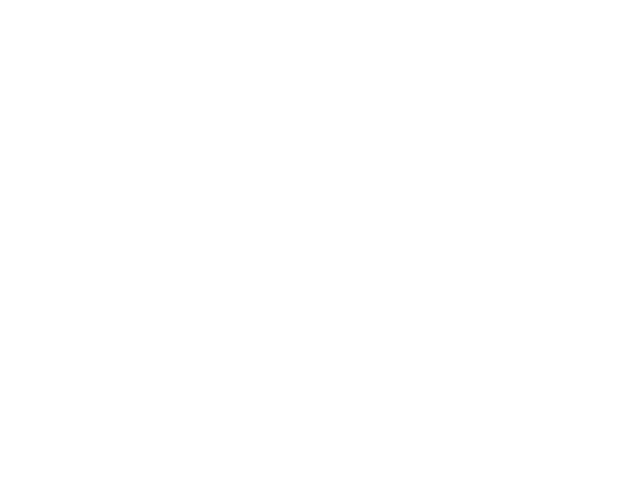

In [59]:
from kevlib import common_import_script
%run $common_import_script

import warnings
from glob import glob

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.utils.exceptions import AstropyWarning
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord

from scipy.ndimage import binary_dilation
from scipy.ndimage import center_of_mass
from scipy.ndimage import label

from kevlib.utils.io import save_pickle, load_pickle

warnings.simplefilter('ignore', category=AstropyWarning)

In [61]:
# good_speed_chains

In [60]:
def plot_images(ims, title='', norm_same=True, fig_height=6, norm_mode='log', norm_kwargs={}, imshow_kwargs={}):
    
    if not isinstance(ims, list): ims = [ims]
    
    n = len(ims)
    
    fig, axs = plt.subplots(1, n, figsize=(n * fig_height, fig_height), sharex=True, sharey=True)
    
    if n == 1: axs = [axs]

    plt.suptitle(title)

    if norm_same:
        norm = simple_norm(ims[0], norm_mode, **norm_kwargs)

    for i in range(n):
        
        if not norm_same:
            norm = simple_norm(ims[i], norm_mode, **norm_kwargs)
        
        axs[i].imshow(ims[i], norm=norm, **imshow_kwargs)
    #

    fig.tight_layout()
    
    return axs


def load_ims(im_id, im_keys):
    im_data = {}
    for k in im_keys:
        data_fp = opj(obs_paths[im_id], k + f'_v{proc_ver}.npy')
        if not os.path.isfile(data_fp):
            data_fp = opj(obs_paths[im_id], k + f'_v{det_ver}.npy')
        im_data[k] = np.load(data_fp)
    return im_data


def iau_to_radecs(iau):
    
    return real_dets.query(f'iau=={iau}')[['ra', 'dec']].values.T


def radec_to_px(ra, dec, im_fp):

    return WCS(im_fp).world_to_pixel(SkyCoord(ra, dec, unit=u.deg))


def proc_dir_to_im_fp(proc_dir):
    
    return proc_dir.replace('_proc', '') + '-w1-int-1b.fits'


def real_det_id_to_my_im_id(real_det_id):
    
    gi = this_real_im_dirs[real_det_id] == obs_paths
    
    if isinstance(gi, bool): gi = np.array([gi])
    
    if gi.any():
    
        return np.argwhere(gi).flatten()[0]
    
    return None


def iau_to_im_dirs(iau, atol=1e-5, return_mjds=False):
    
    mjds_rounded = np.around(mjds, 5)
    
    real_det_mjds = real_dets.query(f'iau=={iau}')['mjd'].values
    
    paths = []
    matched_det_mjds = {}
    
    for mjd in real_det_mjds:
        
        #close_mjds = np.abs(mjd - mjds) < atol
        
        close_mjds = mjd == mjds_rounded
        
        if close_mjds.any():
        
            matched_det_mjds[mjd] = mjds_rounded[close_mjds]

            paths.append( obs_paths[im_ids[close_mjds][0]] )
            
        else:
            
            matched_det_mjds[mjd] = []
            
            paths.append(None)
            
    if return_mjds:
        
        return paths, matched_det_mjds
        
    return paths

In [70]:

ras = np.load("./Crosschecked_Dets/unique_ras_v3_pt4.npy")
decs = np.load("./Crosschecked_Dets/unique_decs_v3_pt4.npy")
pos_mjds = np.load("./Crosschecked_Dets/unique_mjds_v3_pt4.npy")



In [62]:
len(ras)

143561

In [4]:
# ras = [pos_radec[i][0] for i in range(len(pos_radec))]
# decs = [pos_radec[i][1] for i in range(len(pos_radec))]

In [10]:
# singles = np.load("../SummerWork/Deploys/Oct13Search/Singles.npy")
# singles.shape

In [6]:
import pandas as pd

data = {
    'ra': ras,
    'dec': decs,
    'mjd': pos_mjds
    
}

df = pd.DataFrame(data)

df.to_pickle('./coordinates_dataframe.pkl')

dets = load_pickle('coordinates_dataframe.pkl')
len(dets)




im_ids = np.hstack([im_id for im_id, d in enumerate(dets["ra"])])

im_det_ids = np.hstack([im_id for im_id, d in enumerate(dets["ra"])])

mjds = np.hstack([d for d in dets["mjd"]])

radecs = np.stack([
    np.hstack([d for d in dets["ra"]]),
    np.hstack([d for d in dets["dec"]]),
], axis=0)

radecs_rad = np.radians(radecs)

In [8]:
radecs.shape

(2, 143561)

In [9]:
#Filter out bad regions (filters out detections based on known bad image regions in the data I searched)

def filter_radecs(radecs, bad_ra_rngs, bad_dec_rngs):
    
    keep_coords = np.ones(radecs.shape[1], dtype=bool)
    
    for ra_rng, dec_rng in zip(bad_ra_rngs, bad_dec_rngs):
        
        ra_min, ra_max = [np.min(ra_rng), np.max(ra_rng)]
        dec_min, dec_max = [np.min(dec_rng), np.max(dec_rng)]
        bad_ra_indices = (radecs[0] >= ra_min) & (radecs[0] <= ra_max)
        bad_dec_indices = (radecs[1] >= dec_min) & (radecs[1] <= dec_max)
        
        bad_indices = bad_ra_indices & bad_dec_indices
        
        keep_coords = keep_coords & ~bad_indices
        
    return keep_coords


bad_ra_rngs = [
    (176.23, 176.72), (176.43, 176.58), (179.0664, 179.165), (172.431, 172.705), 
    (168.738, 169.005), (6.708, 7.488), (8.156, 8.334), (9.827, 10.065), (11.903, 12.409), (11.99, 12.153), 
    (14.77, 14.913), (18.53, 18.669)]

bad_dec_rngs = [
    (6.841, 6.285), (7.283, 7.084), (14.254, 14.130), (-2.781, -3.182), (-11.376, -11.785), 
    (18.169, 17.539), (17.196, 17.011), (14.325, 14.076), (7.89, 7.392), (7.37, 7.232),
    (0.86, 0.716), (-7.843, -7.976)]


gi = filter_radecs(radecs, bad_ra_rngs, bad_dec_rngs)

im_ids = im_ids[gi]
im_det_ids = im_det_ids[gi]
mjds = mjds[gi].astype(np.float32)
radecs = radecs[:, gi].astype(np.float32)
# xys = xys[:, gi]
radecs_rad = radecs_rad[:, gi].astype(np.float32)

gi.size, np.count_nonzero(gi)

(143561, 143561)

In [10]:
mjds[0],mjds[6000],mjds[9000]

(59805.22, 59806.133, 59806.33)

In [11]:
import numpy as np
from tqdm import tqdm
# this cell's linkage algorithm was adapted from code provided by Kevin Wilis, astronomer.
def calc_thetas(radec_rad, radecs_rad):
    ra_main, dec_main = radec_rad
    ra_others, dec_others = radecs_rad

    sin_diff_ra = np.sin(ra_others - ra_main)
    cos_diff_ra = np.cos(ra_others - ra_main)

    theta = np.arctan2(
        np.cos(dec_others) * sin_diff_ra,
        np.sin(dec_others) * np.cos(dec_main) - np.cos(dec_others) * np.sin(dec_main) * cos_diff_ra
    )

    
    return np.degrees(theta)

def find_links(det_id, theta_last=None, angle_limit=None):
    mjd = mjds[det_id]
    radec = radecs[:, det_id]
    radec_rad = radecs_rad[:, det_id]

    dt = mjds - mjd
    gi = np.where((dt > 0) & (dt < dt_max))[0]

    if gi.size == 0:
        return [] 

    # Velocity constraint filtering (vectorized)
    dradec = radecs[:, gi] - radec[:, None]
    dradt = dradec[0] / dt[gi]
    ddecdt = dradec[1] / dt[gi]

    valid_velocity = (
        (dradt < ra_angular_velocity_limit) & (dradt > 0) &
        (np.abs(ddecdt) < dec_angular_velocity_limit)
    )
    gi = gi[valid_velocity]

    if angle_limit is not None and theta_last is not None:
        theta = calc_thetas(radec_rad, radecs_rad[:, gi])
        valid_angles = np.abs(theta - theta_last) < angle_limit
        gi = gi[valid_angles]

    return gi.tolist()

def recursive_find_links(det_id, theta_last=None, current_chain=None, max_depth=None):
    if current_chain is None:
        current_chain = [det_id]
    if max_depth is not None and len(current_chain) > max_depth:
        return []

    next_det_ids = find_links(det_id, theta_last, angle_limit)

    if not next_det_ids:
        return [current_chain]

    all_chains = []
    thetas_last = calc_thetas(radecs_rad[:, det_id], radecs_rad[:, next_det_ids])

    for next_det_id, theta_last in zip(next_det_ids, thetas_last):
        new_chain = current_chain + [next_det_id]
        extended_chains = recursive_find_links(
            next_det_id, theta_last, new_chain, max_depth
        )
        all_chains.extend(extended_chains)

    return all_chains


def filter_subset_chains(chains):
    unique_chains = []
    seen = set()

    for chain in chains:
        chain_set = frozenset(chain)
        if chain_set not in seen:
            unique_chains.append(chain)
            seen.add(chain_set)

    return unique_chains

# -----------------------------------------------------------------------------------------------------
# Linking limits

ra_angular_velocity_limit = 1
dec_angular_velocity_limit = 1
angle_limit = 1.0
min_link_detections = 3
max_link_detections = 15
dt_max = 0.3

#-----------------------------------------------------------------------------------------------------

all_possible_chains = []
existing_pairs = set()

for det_id in tqdm(range(len(mjds))):
    chains_from_det = recursive_find_links(
        det_id, max_depth=max_link_detections,
    )

    valid_chains = filter_subset_chains(
        [chain for chain in chains_from_det if len(chain) >= min_link_detections]
    )
    valid_chains = [chain for chain in chains_from_det if len(chain) >= min_link_detections]

    # Update existing_pairs to avoid redundant checks
    for chain in valid_chains:
        existing_pairs.update((chain[i], chain[i + 1]) for i in range(len(chain) - 1))

    all_possible_chains.extend(valid_chains)

100%|██████████| 143561/143561 [1:32:31<00:00, 25.86it/s]  


In [12]:
len(all_possible_chains)

6719278

In [41]:
# good_speed_chains

In [16]:

with open("stspaper_good_speed_chains.txt", "w") as file:
    for item in good_speed_chains:
        file.write(str(item) + "\n")

In [14]:
import math

ras = radecs[0]
decs = radecs[1]

allRas = []
allDecs = []
allMjds = []

for i in all_possible_chains:
    
    currRas = []
    currDecs = []
    currMjds = []
    
    for ind in i:
        ra = ras[ind]
        dec = decs[ind]
        time = mjds[ind]
        currRas.append(ra)
        currDecs.append(dec)
        currMjds.append(time)
        
    allRas.append(currRas)
    allDecs.append(currDecs)
    allMjds.append(currMjds)
len(allRas)

def calcSpeed(ras, decs, mjds):
    allSpeeds  = []
    for i in range(len(ras)):
        currSpeeds = []
        for x in range(len(ras[i]) - 1):
            ra1 = ras[i][x]
            dec1 = decs[i][x]
            mjd1 = mjds[i][x]
            # print(mjd1)
            coord1 = [ra1,dec1]
        
            ra2 = ras[i][x+1]
            dec2 = decs[i][x+1]
            mjd2 = mjds[i][x+1]
        
            coord2 = [ra2,dec2]
        
            
            distance = math.dist(coord1, coord2)
            # print(distance)
        
            time_diff = mjd2-mjd1
            # print(time_diff)
        
            speed = distance/time_diff

            currSpeeds.append(speed)
            
        allSpeeds.append(currSpeeds)

    return allSpeeds
        
all_speeds = calcSpeed(allRas, allDecs, allMjds)

all_diffs = []
for ind, link in enumerate(all_speeds):
    diffs = []
    for i in range(len(link) - 1):
        diff = np.abs(link[i] - link[i+1])
        diffs.append(diff)
    
    all_diffs.append(diffs)


good_indices = []

for x, f in enumerate(all_diffs):
    gc = 0
    for m in f:

        if abs(m) < 0.01:
            gc += 1
            
    if gc == len(f):
        good_indices.append(x)

good_speed_chains = [all_possible_chains[i] for i in good_indices]

len(good_speed_chains)

60621

In [44]:
# good_angle_chains

In [45]:
from collections import Counter

flattened = [item for sublist in good_speed_angle_chains for item in sublist]

# Count occurrences of each integer
counts = Counter(flattened)

# Count how many integers appear more than once
num_repeats = sum(1 for count in counts.values() if count > 1)

print(f"Number of repeated integers: {num_repeats}")

Number of repeated integers: 16


In [55]:
from collections import defaultdict, deque
from itertools import combinations

def group_conflicting_tracklets(tracklets):
    n = len(tracklets)

    detection_to_tracklets = defaultdict(set)
    for i, track in enumerate(tracklets):
        for det in track:
            detection_to_tracklets[det].add(i)

    adjacency = defaultdict(set)
    for shared in detection_to_tracklets.values():
        if len(shared) > 1:
            for a, b in combinations(shared, 2):
                adjacency[a].add(b)
                adjacency[b].add(a)

    visited = set()
    groups = []

    for i in range(n):
        if i not in visited:
            stack = [i]
            group = []
            while stack:
                node = stack.pop()
                if node not in visited:
                    visited.add(node)
                    group.append(node)
                    stack.extend(adjacency[node] - visited)
            if len(group) > 1:
                groups.append(group)
    grouped_tracklets = [[tracklets[i] for i in group] for group in groups]
    return grouped_tracklets
grouped_links =  group_conflicting_tracklets(good_speed_angle_chains)

In [68]:
grouped_links =  group_conflicting_tracklets(good_speed_angle_chains)

In [69]:
grouped_links

[[[83823, 94954, 103412, 108872], [88981, 94954, 103412, 108872]],
 [[91573, 100705, 107646, 113570, 118114],
  [100705, 107646, 113570, 118114],
  [97377, 104639, 107646, 113570, 118114],
  [104639, 107646, 113570, 118114]],
 [[96277, 105393, 106910, 112439, 119157], [105393, 106910, 112439, 119157]],
 [[103936, 109613, 115921, 122374], [112678, 115921, 120826, 123618]],
 [[117167, 123131, 127639, 129793], [117167, 123131, 127639, 130794]]]

In [1]:
len(good_speed_chains)

NameError: name 'good_speed_chains' is not defined

In [97]:
# import numpy as np
# from tqdm import tqdm
# from collections import defaultdict, deque
# import numba

# @numba.njit
# def calc_thetas_numba(ra_main, dec_main, ra_others, dec_others):
#     """Numba-optimized vectorized calculation of theta angles."""
#     sin_diff_ra = np.sin(ra_others - ra_main)
#     cos_diff_ra = np.cos(ra_others - ra_main)
#     theta = np.arctan2(
#         np.cos(dec_others) * sin_diff_ra,
#         np.sin(dec_others) * np.cos(dec_main) - np.cos(dec_others) * np.sin(dec_main) * cos_diff_ra
#     )
#     return np.degrees(theta)

# @numba.njit
# def find_valid_indices(mjds, radecs, radecs_rad, det_id, dt_max, 
#                       ra_angular_velocity_limit, dec_angular_velocity_limit):
#     """Numba-optimized function to find valid detection indices."""
#     mjd = mjds[det_id]
#     ra_main = radecs[0, det_id]
#     dec_main = radecs[1, det_id]
    
#     valid_indices = []
    
#     for i in range(len(mjds)):
#         if i == det_id:
#             continue
            
#         dt = mjds[i] - mjd
#         if dt <= 0 or dt >= dt_max:
#             continue
            
#         # Velocity constraints
#         dra = radecs[0, i] - ra_main
#         ddec = radecs[1, i] - dec_main
#         dradt = dra / dt
#         ddecdt = ddec / dt
        
#         if (dradt < ra_angular_velocity_limit and dradt > 0 and 
#             abs(ddecdt) < dec_angular_velocity_limit):
#             valid_indices.append(i)
    
#     return np.array(valid_indices)

# class OptimizedAsteroidLinkage:
#     def __init__(self, mjds, radecs, radecs_rad, config):
#         self.mjds = mjds
#         self.radecs = radecs
#         self.radecs_rad = radecs_rad
#         self.config = config
        
#         # Pre-sort by time for efficient searching
#         self.time_sorted_indices = np.argsort(mjds)
#         self.sorted_mjds = mjds[self.time_sorted_indices]
        
#         # Build spatial index (simple grid-based)
#         self._build_spatial_index()
        
#         # Cache for expensive calculations
#         self.link_cache = {}
        
#     def _build_spatial_index(self):
#         """Build a simple spatial grid index for faster neighbor finding."""
#         # Create coarse spatial grid
#         self.grid_size = 0.1  # degrees
#         self.spatial_grid = defaultdict(list)
        
#         for i in range(len(self.mjds)):
#             ra_grid = int(np.degrees(self.radecs_rad[0, i]) / self.grid_size)
#             dec_grid = int(np.degrees(self.radecs_rad[1, i]) / self.grid_size)
#             self.spatial_grid[(ra_grid, dec_grid)].append(i)
    
#     def _get_spatial_neighbors(self, det_id, search_radius=1):
#         """Get potential neighbors from spatial grid."""
#         ra_grid = int(np.degrees(self.radecs_rad[0, det_id]) / self.grid_size)
#         dec_grid = int(np.degrees(self.radecs_rad[1, det_id]) / self.grid_size)
        
#         neighbors = []
#         for dra in range(-search_radius, search_radius + 1):
#             for ddec in range(-search_radius, search_radius + 1):
#                 grid_key = (ra_grid + dra, dec_grid + ddec)
#                 neighbors.extend(self.spatial_grid.get(grid_key, []))
        
#         return np.array(neighbors, dtype=np.int32)
    
#     def find_links_optimized(self, det_id, theta_last=None):
#         """Optimized link finding with caching and spatial indexing."""
#         cache_key = (det_id, theta_last)
#         if cache_key in self.link_cache:
#             return self.link_cache[cache_key]
        
#         # Get spatial neighbors first
#         spatial_candidates = self._get_spatial_neighbors(det_id)
#         if len(spatial_candidates) == 0:
#             self.link_cache[cache_key] = []
#             return []
        
#         # Use numba-optimized function for velocity filtering
#         valid_indices = find_valid_indices(
#             self.mjds, self.radecs, self.radecs_rad, det_id,
#             self.config['dt_max'], 
#             self.config['ra_angular_velocity_limit'],
#             self.config['dec_angular_velocity_limit']
#         )
        
#         # Intersect with spatial candidates
#         valid_indices = np.intersect1d(valid_indices, spatial_candidates)
        
#         if len(valid_indices) == 0:
#             self.link_cache[cache_key] = []
#             return []
        
#         # Angle filtering if needed
#         if self.config['angle_limit'] is not None and theta_last is not None:
#             thetas = calc_thetas_numba(
#                 self.radecs_rad[0, det_id], self.radecs_rad[1, det_id],
#                 self.radecs_rad[0, valid_indices], self.radecs_rad[1, valid_indices]
#             )
#             valid_angles = np.abs(thetas - theta_last) < self.config['angle_limit']
#             valid_indices = valid_indices[valid_angles]
        
#         result = valid_indices.tolist()
#         self.link_cache[cache_key] = result
#         return result
    
#     def iterative_find_chains(self, start_det_id, max_depth):
#         """Iterative chain finding using BFS to avoid recursion overhead."""
#         all_chains = []
        
#         # Use deque for BFS
#         queue = deque([(start_det_id, [start_det_id], None)])  # (current_id, chain, last_theta)
        
#         while queue:
#             current_id, current_chain, theta_last = queue.popleft()
            
#             if len(current_chain) > max_depth:
#                 continue
            
#             next_ids = self.find_links_optimized(current_id, theta_last)
            
#             if not next_ids:
#                 # End of chain
#                 if len(current_chain) >= self.config['min_link_detections']:
#                     all_chains.append(current_chain.copy())
#                 continue
            
#             # Calculate thetas for next detections
#             if len(next_ids) > 0:
#                 thetas = calc_thetas_numba(
#                     self.radecs_rad[0, current_id], self.radecs_rad[1, current_id],
#                     self.radecs_rad[0, next_ids], self.radecs_rad[1, next_ids]
#                 )
                
#                 for next_id, theta in zip(next_ids, thetas):
#                     new_chain = current_chain + [next_id]
#                     queue.append((next_id, new_chain, theta))
        
#         return all_chains
    
#     def find_all_chains_optimized(self):
#         """Main optimized chain finding function."""
#         all_chains = []
#         processed_starts = set()
        
#         # Process detections in time order for better efficiency
#         for idx in tqdm(self.time_sorted_indices):
#             if idx in processed_starts:
#                 continue
            
#             chains = self.iterative_find_chains(idx, self.config['max_link_detections'])
            
#             # Filter and deduplicate chains
#             valid_chains = []
#             for chain in chains:
#                 if len(chain) >= self.config['min_link_detections']:
#                     chain_set = frozenset(chain)
#                     # Simple deduplication check
#                     is_duplicate = any(frozenset(existing) >= chain_set for existing in valid_chains)
#                     if not is_duplicate:
#                         valid_chains.append(chain)
#                         # Mark all detections in this chain as processed
#                         processed_starts.update(chain)
            
#             all_chains.extend(valid_chains)
        
#         return all_chains

# # Usage function
# """Main function to run the optimized linkage algorithm."""

# # Configuration
# config = {
#     'ra_angular_velocity_limit': 0.4,
#     'dec_angular_velocity_limit': 0.4,
#     'angle_limit': 0.2,
#     'min_link_detections': 3,
#     'max_link_detections': 15,
#     'dt_max': 0.1
# }

# # Create optimizer instance
# optimizer = OptimizedAsteroidLinkage(mjds, radecs, radecs_rad, config)

# # Find all chains
# print("Finding asteroid linkage chains...")
# all_chains = optimizer.find_all_chains_optimized()


In [23]:
with open('stspaper_good_speed_chains_4and5.txt', 'w') as f:
    for sublist in good_speed_chains:
        f.write(' '.join(map(str, sublist)) + '\n')


In [63]:
good_speed_chains = []

with open('stspaper_good_speed_chains_4and5.txt', 'r') as f:
    for line in f:
        # Split the line into strings and convert each to the appropriate type (e.g., int or float)
        sublist = list(map(int, line.strip().split()))
        if len(sublist) >=4:
            good_speed_chains.append(sublist)


In [64]:
len(good_speed_chains)

898

In [65]:
# ims = np.load("./Searches/v3_images_pt9.npy")
# pix_coords = np.load("./Searches/v3_predicted_CoordinatesPixels_pt9.npy")

# ims = np.load("./unique_Images_v3_pt9.npy")
# pix_coords = np.load("./unique_pixCoords_v3_pt9.npy")


ims=np.load("./unique_Images_v3_pt4.npy")

pix_coords = np.load("./unique_pixCoords_v3_pt4.npy")

In [25]:
len(longs)

898

In [9]:
longs = [c for c in good_speed_chains if len(c)>= 4]

In [58]:
plt.close()

In [17]:
# for x in range(0, len(good_speed_chains)):
#     if len(good_speed_chains[x]) ==4:
#         plot_images([ims[i] for i in good_speed_chains[x]], title = " index: %d" % x, fig_height=2.2)

In [151]:
x = 640
print(good_speed_chains[x])

sub_i=1
print(ras[good_speed_chains[x][sub_i]], decs[good_speed_chains[x][sub_i]], mjds[good_speed_chains[x][sub_i]])

"""
245 - (2026) Cottrell 1955 FF
350 - (44024) 1997 WP47
552 - known
327- known
322 - (5030) Gyldenkerne 1988 VK4
307 - (5030) Gyldenkerne 1988 VK4


366, 669, 741

5: 640
"""

[9147, 9505, 10459, 11099, 11942]
52.536266 21.746246 59811.35


'\n245 - (2026) Cottrell 1955 FF\n350 - (44024) 1997 WP47\n552 - known\n327- known\n322 - (5030) Gyldenkerne 1988 VK4\n307 - (5030) Gyldenkerne 1988 VK4\n\n\n366, 669, 741\n\n5: 365\n'

In [16]:
### for x in range(len(good_speed_cleaned_chains)):
import math
x = 40

good_speed_clean_ra = [ras[i] for i in good_speed_chains[x]]
good_speed_clean_dec = [decs[i] for i in good_speed_chains[x]]
good_speed_clean_mjd = [mjds[i] for i in good_speed_chains[x]]

good_clean_speeds = [math.dist([good_speed_clean_ra[i], good_speed_clean_dec[i]], 
                               [good_speed_clean_ra[i+1], good_speed_clean_dec[i+1]]) / 
                                 (good_speed_clean_mjd[i+1] - good_speed_clean_mjd[i]) for i in range(len(good_speed_clean_ra) - 1)]

good_clean_speeds_diffs =  [good_clean_speeds[i+1] - good_clean_speeds[i] for i in range(len(good_clean_speeds)-1)]

print(good_speed_chains[x])

q = 1
print(good_speed_clean_ra[q], good_speed_clean_dec[q], good_speed_clean_mjd[q])

print("Ras: ", good_speed_clean_ra, "\n")
print("Decs: ", good_speed_clean_dec, "\n")
print("Mjds: ", good_speed_clean_mjd, "\n")
print("The speeds are: ", good_clean_speeds, "\n")
print("The differences are: ",good_clean_speeds_diffs ,"\n")

plot_images([ims[i] for i in good_speed_chains[x]], title = str(good_speed_chains[x]) + " index: at %d" % (x), fig_height=2, norm_same=False)

[9114, 11075, 15942, 18175]
50.08055224052525 21.72902034437033 59806.45827977
Ras:  [49.99191010655868, 50.08055224052525, 50.26209845277338, 50.35076556056178] 

Decs:  [21.7145683930856, 21.72902034437033, 21.759681114731116, 21.775811857099903] 

Mjds:  [59806.32788582, 59806.45827977, 59806.71919476, 59806.84958922] 

The speeds are:  [0.688778192604417, 0.7056593778925823, 0.6911524827439658] 

The differences are:  [0.01688118528816529, -0.014506895148616472] 



NameError: name 'ims' is not defined

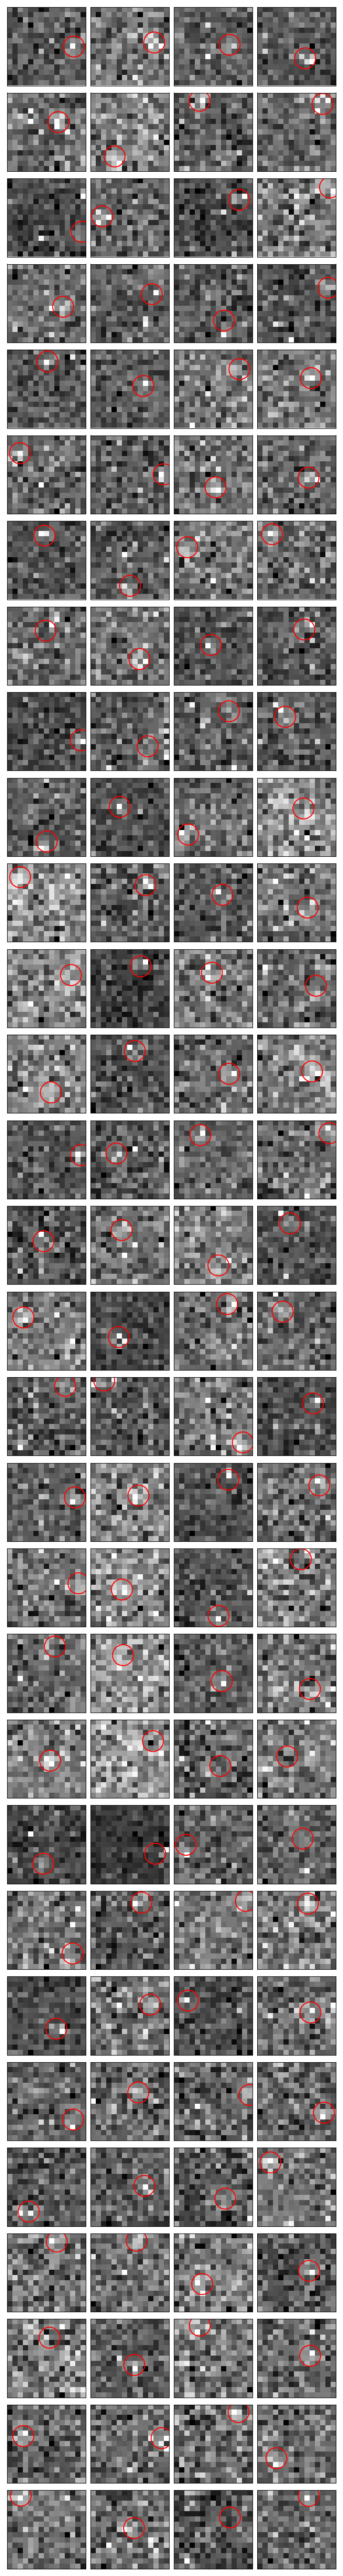

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_chains_with_coords(ims, pix_coords, chains, max_chain_len=None):

    num_chains = len(chains)
    max_len = max(len(chain) for chain in chains)
    n_cols = max_chain_len if max_chain_len is not None else max_len

    fig, axes = plt.subplots(num_chains, n_cols, figsize=(1.8 * n_cols, 1.8 * num_chains))
    
    if num_chains == 1:
        axes = [axes]

    for row_idx, chain in enumerate(chains):
        for col_idx in range(n_cols):
            ax = axes[row_idx][col_idx] if num_chains > 1 else axes[col_idx]

            if col_idx < len(chain):
                idx = chain[col_idx]
                image = ims[idx]
                coord = pix_coords[idx]

                ax.imshow(image, cmap='gray', origin='lower')
                circ = patches.Circle((coord[0], coord[1]), radius=2.0, color='red', fill=False, linewidth=1.5)
                ax.add_patch(circ)
            else:
                ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()


ims=np.load("./unique_Images_v3_pt4.npy")

pix_coords = np.load("./unique_pixCoords_v3_pt4.npy")
#millions of background pixels of random noise - > problty that the source appears in the noise -less than 
# false alarm probability test - problty that the object was made by noise - another factor like mean of a chain to prove validity

plot_chains_with_coords(ims, pix_coords, good_speed_angle_chains[0:30])

In [52]:
plt.close()

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches

# def plot_chains_with_coords(ims, pix_coords, chains, max_chain_len=None):

#     num_chains = len(chains)
#     max_len = max(len(chain) for chain in chains)
#     n_cols = max_chain_len if max_chain_len is not None else max_len

#     fig, axes = plt.subplots(num_chains, n_cols, figsize=(1.8 * n_cols, 1.8 * num_chains))
    
#     if num_chains == 1:
#         axes = [axes]

#     for row_idx, chain in enumerate(chains):
#         for col_idx in range(n_cols):
#             ax = axes[row_idx][col_idx] if num_chains > 1 else axes[col_idx]

#             if col_idx < len(chain):
#                 idx = chain[col_idx]
#                 image = ims[idx]
#                 coord = pix_coords[idx]

#                 ax.imshow(image, cmap='gray', origin='lower')
#                 circ = patches.Circle((coord[0], coord[1]), radius=2.0, color='red', fill=False, linewidth=1.5)
#                 ax.add_patch(circ)
#             else:
#                 ax.axis('off')
#             ax.set_xticks([])
#             ax.set_yticks([])

#     plt.tight_layout()
#     plt.show()


# ims=np.load("./unique_Images_v3_pt4.npy")

# pix_coords = np.load("./unique_pixCoords_v3_pt4.npy")

# plot_chains_with_coords(ims, pix_coords, longs[0:100])

In [24]:
plt.close()

In [69]:
# good_speed_chains[0:]

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# predictedCoords = np.load("./BlindSearch_predCoords_Oct13SearchData_V9_pt2_testCoordCNN.npy")
# W2ims = np.load("./Oct13SearchData_PositiveImages_V9_pt2_testCoordCNN.npy")  # W2 images
# bitmasks = np.load("../SummerWork/Deploys/Oct13Search/Bitmasks.npy")            # Bitmask images
# coadds = np.load("../SummerWork/Deploys/Oct13Search/Coadds.npy")              # Coadded images
# pos_confidences = np.load("./Oct13_V9_pt2_posConfidences.npy")

# # Define the radius of the circle (in pixels)
# circle_radius = 2

# row_titles = ['W2ims', 'Bitmasks', 'Coadds']
# image_arrays = [W2ims, bitmasks, coadds]

# pdf_filename = 'chains_plots.pdf'
# with PdfPages(pdf_filename) as pdf:
#     # Loop through each chain
#     for chain_idx, chain in enumerate(good_speed_chains):
#         n = len(chain)  # number of detections in this chain

#         # Create a figure with 3 rows (one for each image type) and n columns (one per detection)
#         fig, axes = plt.subplots(3, n, figsize=(n * 3, 9))
        
#         # In case there is only one detection, ensure axes is 2D
#         if n == 1:
#             axes = axes.reshape(3, 1)
            
#         # Loop over each detection in the chain
#         for col, img_index in enumerate(chain):
#             # Set the title above the column with the confidence value
#             confidence = pos_confidences[img_index]
#             axes[0, col].set_title(f"Confidence: {confidence:.2f}", fontsize=10)
            
#             # Loop over each image type (row)
#             for row in range(3):
#                 ax = axes[row, col]
#                 # Retrieve the image from the proper array
#                 img = image_arrays[row][img_index]
                
#                 # If the image is a 1D array with 225 elements, reshape it to 15x15
#                 if img.ndim == 1 and img.size == 225:
#                     img = img.reshape((15, 15))
                
#                 ax.imshow(img, cmap='gray')
#                 ax.axis('off')
                
#                 # Get the predicted coordinate (assumed to be (x,y))
#                 coord = predictedCoords[img_index]
#                 circle = plt.Circle((coord[0], coord[1]), circle_radius, color='red', fill=False, linewidth=2)
#                 ax.add_patch(circle)
                
#                 # Label the first column with the image type for clarity
#                 if col == 0:
#                     ax.set_ylabel(row_titles[row], fontsize=12)
        
#         # Title the figure with the chain number
#         fig.suptitle(f"Chain {chain_idx}", fontsize=16)
#         plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         pdf.savefig(fig)
#         plt.close(fig)

# print(f"PDF saved as {pdf_filename}")


In [66]:
W2ims = np.load("./Searches/V2_Apr9_pos_pt5_664k_2moreconvlayers.npy")  # W2 images
len(W2ims)

409615

In [1]:
from kevlib.utils.io import mmcreate, mmload
import numpy as np

In [5]:
len(known_indices)

2972

143561

# normal - plot links to PDF

In [42]:
all_confidences  = np.load("./Searches/v3_all_confidences_S1.npy")
pos_indices = [i for i in range(len(all_confidences)) if all_confidences[i] >= 0.4]
known_mask=np.load("matched_irsa_knowns_S1_pt4_v3.npy")
W1allims = mmload("./Searches/2_S1_initial_deploy_grids_W1.npy")

w1inds = np.arange(len(W1allims))

w1inds = w1inds[pos_indices]

w1inds = w1inds[~known_mask]

unique_confidences = all_confidences[w1inds]
W1ims = W1allims[w1inds]

len(unique_confidences)

143561

In [2]:
good_speed_chains = []

with open('stspaper_good_speed_chains_4and5.txt', 'r') as f:
    for line in f:
        # Split the line into strings and convert each to the appropriate type (e.g., int or float)
        sublist = list(map(int, line.strip().split()))
        if len(sublist) >=4:
            good_speed_chains.append(sublist)

good_angle_chains = [1, 5, 10, 12, 13, 22, 26, 29, 33, 35, 40, 45, 47, 55, 58, 63, 70, 74, 78, 80, 85, 86, 87, 91, 92, 107, 109, 114, 119, 120, 123, 126, 127, 130, 134, 138, 139, 148, 149, 151, 154, 157, 164, 166, 168, 178, 181, 185, 194, 198, 203, 208, 210, 228, 229, 234, 236, 238, 242, 247, 268, 279, 310, 317, 327, 328, 336, 337, 345, 348, 351, 352, 357, 359, 361, 369, 370, 373, 382, 386, 400, 405, 417, 419, 420, 424, 431, 434, 435, 440, 450, 457, 462, 477, 480, 497, 508, 512, 516, 521, 532, 538, 539, 543, 557, 558, 561, 562, 570, 575, 577, 586, 587, 594, 599, 601, 609, 611, 613, 614, 616, 618, 619, 621, 622, 632, 653, 657, 671, 672, 673, 683, 694, 697, 704, 708, 710, 712, 715, 716, 717, 727, 728, 734, 735, 737, 740, 747, 766, 779, 791, 795, 802, 804, 811, 812, 819, 821, 822, 830, 832, 845, 853, 854, 862, 863, 865, 868, 877, 889, 892]
#greater than 45 deg:
# good_angle_chains = [0, 7, 8, 9, 18, 19, 21, 24, 27, 30, 37, 38, 42, 48, 49, 52, 57, 59, 64, 66, 68, 69, 75, 77, 79, 82, 84, 89, 90, 93, 94, 98, 105, 106, 110, 124, 125, 131, 132, 137, 145, 156, 159, 163, 165, 175, 176, 186, 189, 190, 192, 196, 201, 207, 209, 211, 212, 216, 225, 226, 227, 237, 239, 240, 243, 245, 251, 253, 256, 261, 262, 263, 264, 266, 270, 278, 283, 284, 286, 290, 292, 300, 302, 303, 306, 308, 309, 316, 319, 324, 325, 329, 331, 339, 341, 342, 343, 344, 347, 360, 362, 371, 376, 385, 389, 391, 398, 401, 402, 403, 404, 407, 410, 412, 414, 415, 416, 418, 423, 425, 426, 427, 428, 432, 433, 436, 443, 444, 447, 449, 452, 455, 456, 459, 461, 465, 468, 469, 473, 475, 491, 494, 501, 504, 506, 517, 518, 526, 528, 529, 534, 536, 540, 541, 544, 548, 551, 552, 554, 555, 564, 565, 569, 571, 574, 584, 591, 592, 598, 604, 605, 610, 617, 633, 636, 637, 640, 641, 642, 647, 649, 658, 659, 660, 664, 665, 682, 684, 687, 693, 695, 696, 703, 713, 719, 723, 731, 732, 733, 736, 738, 742, 752, 756, 758, 760, 761, 764, 769, 772, 778, 781, 783, 784, 792, 798, 803, 805, 813, 817, 818, 824, 826, 833, 834, 835, 837, 839, 843, 846, 850, 851, 855, 864, 871, 873, 883, 884, 886, 887, 888, 893, 894]

# less than -45:
# good_angle_chains = [3, 4, 16, 20, 34, 43, 50, 60, 61, 65, 72, 76, 83, 99, 100, 101, 102, 103, 111, 117, 135, 136, 140, 141, 143, 144, 147, 152, 162, 171, 172, 182, 183, 197, 199, 205, 206, 218, 223, 233, 248, 250, 267, 287, 296, 297, 299, 311, 322, 323, 338, 340, 346, 350, 353, 354, 363, 367, 378, 384, 388, 393, 397, 411, 422, 437, 442, 448, 460, 464, 481, 487, 488, 489, 490, 492, 493, 495, 500, 502, 503, 505, 507, 509, 510, 511, 514, 519, 531, 537, 542, 566, 572, 573, 581, 582, 585, 588, 589, 596, 600, 607, 623, 629, 639, 648, 650, 651, 654, 661, 667, 670, 674, 675, 681, 685, 686, 688, 689, 690, 691, 692, 699, 718, 721, 724, 725, 744, 745, 750, 751, 755, 757, 759, 763, 765, 771, 775, 786, 790, 793, 800, 801, 815, 816, 828, 841, 847, 849, 875, 880, 882]
good_speed_angle_chains = [good_speed_chains[i] for i in range(len(good_speed_chains)) if i in good_angle_chains]
len(good_speed_angle_chains)

171

In [3]:
len(good_speed_chains)

898

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

predictedCoords  = np.load("./unique_pixCoords_v3_pt4.npy")
W2ims = np.load("./unique_Images_v3_pt4.npy")


# bitmasks = np.load("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_bitmasks.npy")
# coadds   = np.load("./Searches/Mar19_Search_DarkPixelsRemoved_Normalized_coa.npy")


circle_radius = 2

row_titles    = ['W1', "W2"] 
image_arrays  = [W1ims, W2ims]
n_rows        = len(image_arrays)

assert all(len(arr) == len(predictedCoords) for arr in image_arrays)

pdf_filename = 'NewLinks_Less_Than_Negative45deg_Angles.pdf'
with PdfPages(pdf_filename) as pdf:
    for chain_idx, chain in enumerate(good_speed_angle_chains[:]):   # first 10 chains
        n = len(chain)
        if n < 1:
            continue 

        fig, axes = plt.subplots(
            n_rows, n,
            figsize=(n * 3 + 1, n_rows * 3),
            squeeze=False 
        )

        for col, img_idx in enumerate(chain):
            conf = unique_confidences[img_idx]
            axes[0, col].set_title(f"Confidence: {conf:.2f}", fontsize=10)


            for row in range(n_rows):
                ax  = axes[row, col]
                img = image_arrays[row][img_idx]

                ax.imshow(img, cmap='gray', origin='lower')  # origin='lower' → (0,0) bottom-left
                # ax.axis('off')

                # draw predicted coordinate
                x, y = predictedCoords[img_idx]
                circ = plt.Circle((x, y), radius=circle_radius,
                                  edgecolor='red', facecolor='none', linewidth=2)
                ax.add_patch(circ)

                if col == 0:
                    ax.set_ylabel(row_titles[row], fontsize=10)

        fig.suptitle(f"Chain {chain_idx}", fontsize=16)
        # plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved as '{pdf_filename}'")

PDF saved as 'NewLinks_Less_Than_Negative45deg_Angles.pdf'


# Grouped matching link decision making

In [72]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

predictedCoords  = np.load("./unique_pixCoords_v3_pt4.npy")
W2ims            = np.load("./unique_Images_v3_pt4.npy")
pos_confidences  = np.load("./Searches/v3_all_confidences_S1.npy")
pos_confidences = [p for p in pos_confidences if p >= 0.4]

# ras = np.load("./ras.npy")
# decs = np.load("./decs.npy")

circle_radius = 2
row_titles    = ['W2ims']
image_arrays  = [W2ims]
n_rows_per_chain = len(image_arrays)
n_rows_with_plot = n_rows_per_chain + 1

pdf_filename = 'correct_angle_links_decisions_correct_confidences.pdf'
with PdfPages(pdf_filename) as pdf:
    for page_idx, group in enumerate(grouped_links):
        n_chains = len(group)
        max_chain_length = max(len(chain) for chain in group)

        # Now include the extra row for each chain
        fig, axes = plt.subplots(
            n_chains * n_rows_with_plot, max_chain_length,
            figsize=(max_chain_length * 3, n_chains * n_rows_with_plot * 3),
            squeeze=False
        )

        for chain_idx, chain in enumerate(group):
            ra_chain = [ras[i] for i in chain]
            dec_chain = [decs[i] for i in chain]

            for col, img_idx in enumerate(chain):
                conf = pos_confidences[img_idx]
                for row in range(n_rows_per_chain):
                    ax_row = chain_idx * n_rows_with_plot + row
                    ax = axes[ax_row, col]
                    img = image_arrays[row][img_idx]

                    if img.ndim == 1 and img.size == 225:
                        img = img.reshape(15, 15)

                    ax.imshow(img, cmap='gray', origin='lower')
                    ax.axis('off')

                    x, y = predictedCoords[img_idx]
                    circ = plt.Circle((x, y), radius=circle_radius, edgecolor='red', facecolor='none', linewidth=2)
                    ax.add_patch(circ)

                    if col == 0:
                        ax.set_ylabel(f"{row_titles[row]}\nChain {chain_idx}", fontsize=10)

                axes[chain_idx * n_rows_with_plot, col].set_title(f"Conf: {conf:.2f}", fontsize=8)

            ra_dec_ax = axes[chain_idx * n_rows_with_plot + n_rows_per_chain, 0]
            for col in range(1, max_chain_length):
                axes[chain_idx * n_rows_with_plot + n_rows_per_chain, col].axis('off')  # turn off unused RA/DEC axes

            ra_dec_ax.plot(ra_chain, dec_chain, '-o', color='blue', linewidth=2)
            ra_dec_ax.set_xlabel('RA')
            ra_dec_ax.set_ylabel('Dec')
            ra_dec_ax.set_title(f"RA/DEC Path — Chain {chain_idx}")
            ra_dec_ax.grid(True)

        fig.suptitle(f"Page {page_idx + 1}: {n_chains} chains", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved as '{pdf_filename}'")


PDF saved as 'correct_angle_links_decisions_correct_confidences.pdf'


In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

def angle_from_horizontal(p1, p2):
    delta_ra = p2[0] - p1[0]
    delta_dec = p2[1] - p1[1]
    angle_rad = np.arctan2(delta_dec, delta_ra)
    return np.degrees(angle_rad)


with PdfPages(pdf_filename) as pdf:
    for page_idx, group in enumerate(grouped_links):
        n_chains = len(group)
        max_chain_length = max(len(chain) for chain in group)

        fig, axes = plt.subplots(
            n_chains * n_rows_with_plot, max_chain_length,
            figsize=(max_chain_length * 3, n_chains * n_rows_with_plot * 3),
            squeeze=False
        )

        for chain_idx, chain in enumerate(group):
            ra_chain = [ras[i] for i in chain]
            dec_chain = [decs[i] for i in chain]

            for col, img_idx in enumerate(chain):
                conf = pos_confidences[img_idx]

                angle_horiz = None
                if col < len(chain) - 1:
                    i1, i2 = chain[col], chain[col + 1]
                    angle_horiz = angle_from_horizontal(
                        (ras[i1], decs[i1]),
                        (ras[i2], decs[i2])
                    )

                for row in range(n_rows_per_chain):
                    ax_row = chain_idx * n_rows_with_plot + row
                    ax = axes[ax_row, col]
                    img = image_arrays[row][img_idx]

                    if img.ndim == 1 and img.size == 225:
                        img = img.reshape(15, 15)

                    ax.imshow(img, cmap='gray', origin='lower')
                    ax.axis('off')

                    x, y = predictedCoords[img_idx]
                    circ = plt.Circle((x, y), radius=circle_radius, edgecolor='red', facecolor='none', linewidth=2)
                    ax.add_patch(circ)

                    if col == 0:
                        ax.set_ylabel(f"{row_titles[row]}\nChain {chain_idx}", fontsize=10)

                # Set title above the image with angle
                title_text = f"Conf: {conf:.2f}"
                if angle_horiz is not None:
                    title_text += f"\nAngle: {angle_horiz:.1f}°"
                axes[chain_idx * n_rows_with_plot, col].set_title(title_text, fontsize=8)

            # RA/DEC path plot
            ra_dec_ax = axes[chain_idx * n_rows_with_plot + n_rows_per_chain, 0]
            for col in range(1, max_chain_length):
                axes[chain_idx * n_rows_with_plot + n_rows_per_chain, col].axis('off')

            ra_dec_ax.plot(ra_chain, dec_chain, '-o', color='blue', linewidth=2)
            ra_dec_ax.set_xlabel('RA')
            ra_dec_ax.set_ylabel('Dec')
            ra_dec_ax.set_title(f"RA/DEC Path — Chain {chain_idx}")
            ra_dec_ax.grid(True)

        fig.suptitle(f"Page {page_idx + 1}: {n_chains} chains", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        pdf.savefig(fig)
        plt.close(fig)

print(f"PDF saved as '{pdf_filename}'")


PDF saved as 'correct_angle_links_decisions_correct_confidences.pdf'


In [77]:
repeats = []
for c in longs:
    for val in c:
        if val not in repeats:
            repeats.append(val)

# Works


In [44]:
inds = [i for i in range(len(good_speed_chains)) if len(good_speed_chains[i]) > 5]

# Real Stats plotting

In [100]:
real_dets_df = pd.read_csv('/media/rd3/neowisedl/neowiseObs.csv', dtype = {'iau_str': str})

real_dets = real_dets_df.query(f"{mjd_folder} <mjd < {mjd_folder+1}")

real_dets = real_dets.groupby('iau').filter(lambda x: len(x) > 1)

real_iaus = real_dets['iau'].to_numpy()

real_mjds = real_dets['mjd'].to_numpy()

real_elons = real_dets['elon'].to_numpy()
real_elats = real_dets['elat'].to_numpy()

real_ras = real_dets['ra'].to_numpy()

real_decs = real_dets['dec'].to_numpy()

unique_iaus = np.unique(real_dets['iau'].values)

# unique_iaus

FileNotFoundError: [Errno 2] No such file or directory: '/media/rd3/neowisedl/neowiseObs.csv'

In [69]:
real_det_stats = dict(
    dt=[],
    dra=[],
    ddec=[],
)

for iau_ix, iau in enumerate(unique_iaus):
    
    real_dets_df_cut = real_dets_df.query(f'iau == {iau}')
    
    for k, k0 in zip(real_det_stats.keys(), ['mjd', 'ra', 'dec']):
        
        endings = real_dets_df_cut['ending'].values
        
        for sg_ix, end_str in enumerate(np.unique(endings)):
        
            gi = endings == end_str
            
            real_det_stats[f'{k}'].append( np.diff(real_dets_df_cut[k0].values[gi]) )


for k in real_det_stats.keys():

    real_det_stats[f'{k}'] = np.hstack(real_det_stats[f'{k}'])
#


<IPython.core.display.Javascript object>


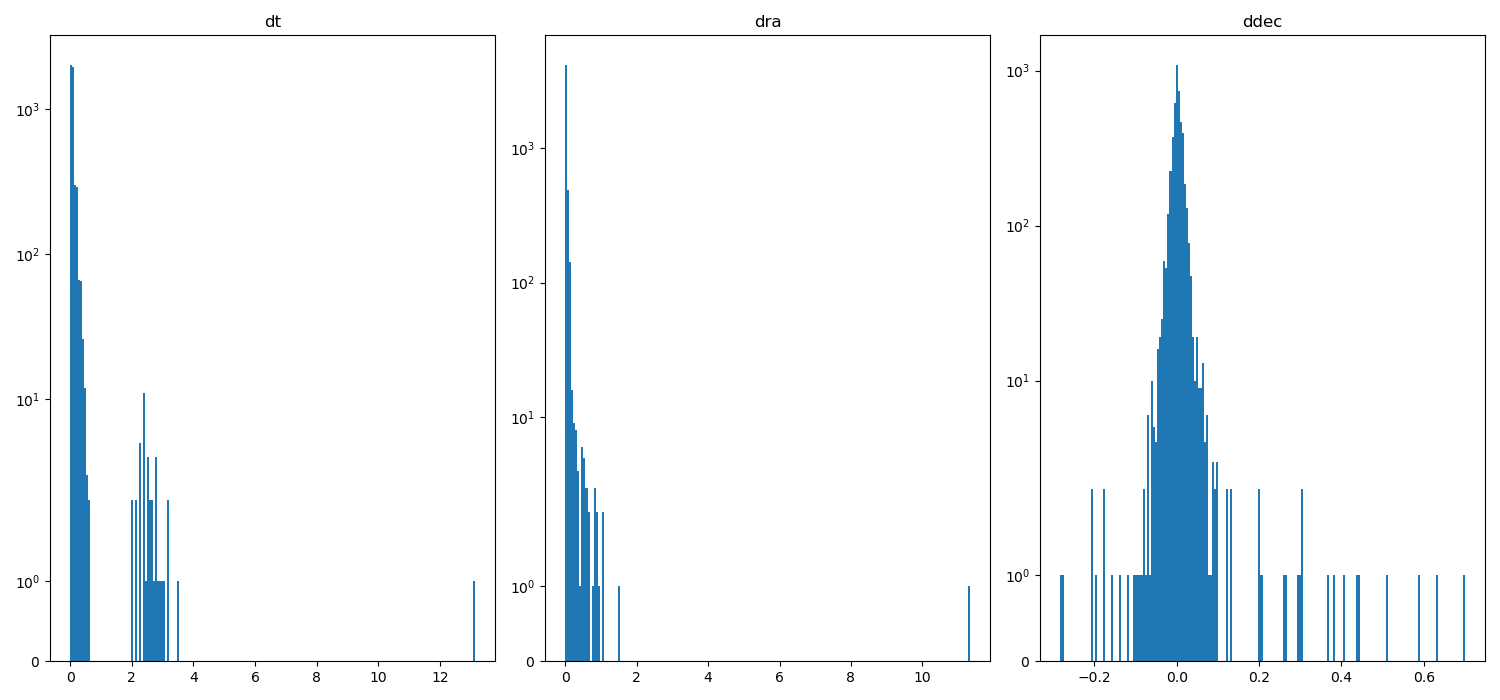

<IPython.core.display.Javascript object>


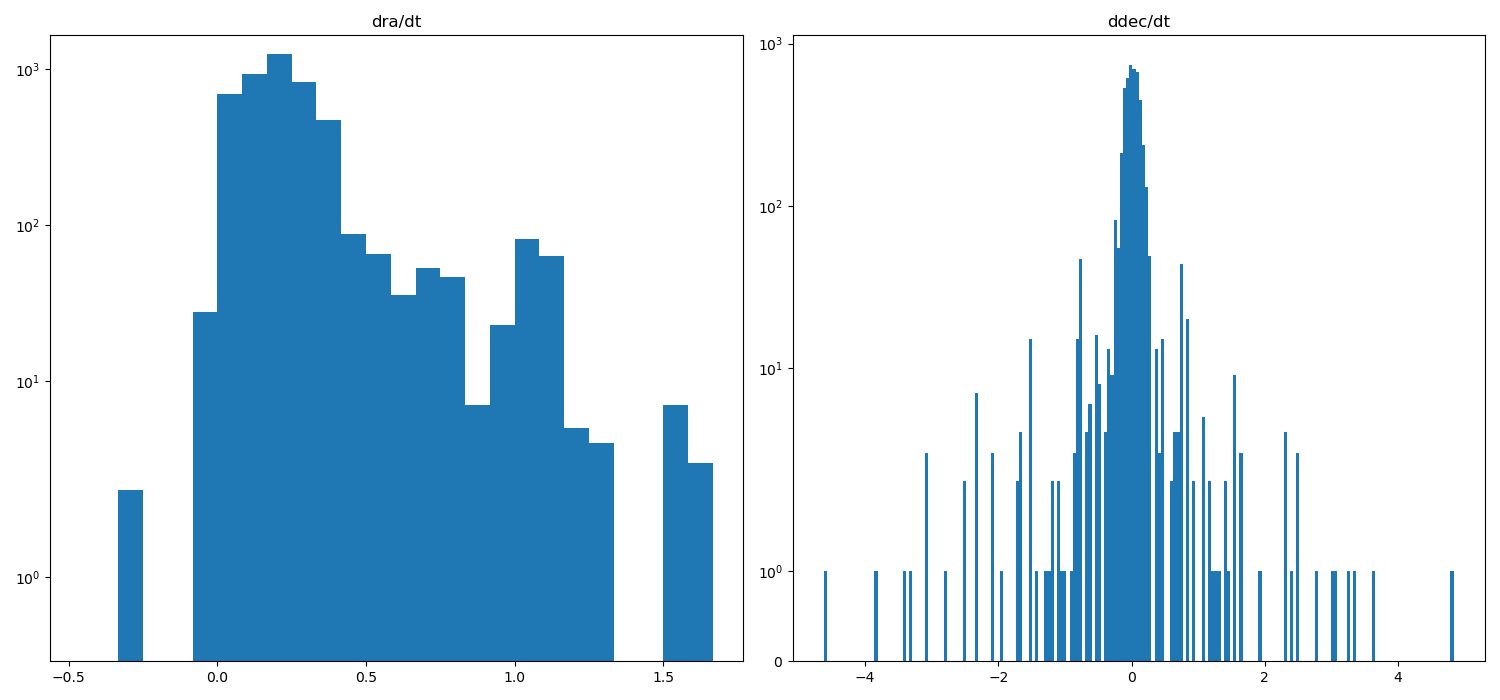

In [156]:
# Plots of known NEO stats. Used to help define linking limits/criteria

fig, axs = plt.subplots(1, 3, figsize=(15, 7))

for i, (k, v) in enumerate(real_det_stats.items()):
    
    axs[i].hist(v, bins=200)
    axs[i].set(title=k, yscale='symlog')
        
fig.tight_layout()


fig, axs = plt.subplots(1, 2, figsize=(15, 7))
i = 0
axs[i].hist(real_det_stats['dra'] / real_det_stats['dt'], bins=200)
axs[i].set(title='dra/dt', yscale='symlog')
i += 1
axs[i].hist(real_det_stats['ddec'] / real_det_stats['dt'], bins=200)
axs[i].set(title='ddec/dt', yscale='symlog')
        
fig.tight_layout()

# Linkage plot

In [46]:
len(ras)

209543

In [113]:
plt.close()

Text(0.5, 1.0, 'CNN Asteroid Candidates')

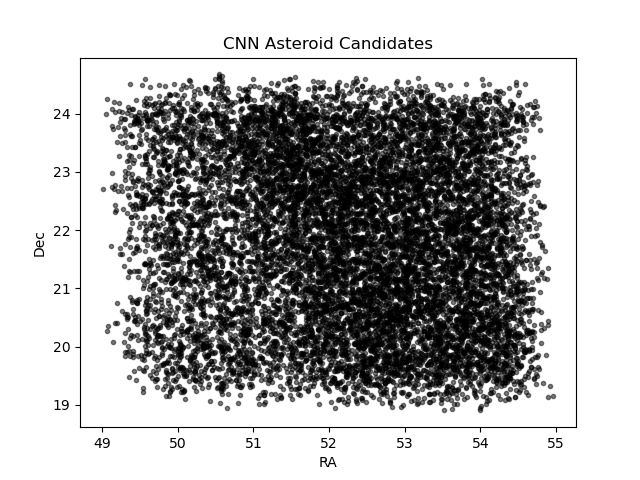

In [33]:
plt.figure()

plt.plot(ras,decs, ".k",alpha=0.5)
plt.xlabel("RA")
plt.ylabel("Dec")
plt.title("CNN Asteroid Candidates")

In [25]:
radecs[0, good_speed_chains[1]]

array([49.75973804, 49.9840905 , 50.21102718, 50.43872254])

In [32]:
first_last

[[[49.66350405872077, 19.707400203481107],
  [49.892847242254106, 20.25979123112115]],
 [[49.75973804010552, 20.174595332939656],
  [50.43872253854857, 20.492234678142832]],
 [[49.62602997136466, 19.16451198905116],
  [50.39202942407991, 19.703775591888043]],
 [[50.331468366860946, 20.089082133765473],
  [50.51113985564762, 19.392771457965637]],
 [[50.143284178481295, 20.555510841710376],
  [50.499569195992734, 19.998097759124338]],
 [[49.89867778479581, 20.363719882965196],
  [50.315142123601596, 20.448154570002167]],
 [[49.659466140355946, 20.031719536062436],
  [50.15520914238086, 19.87598341239309]],
 [[50.117488682050094, 19.74725039317237],
  [50.27898175909301, 20.071655561999087]],
 [[50.02922817556524, 19.630841847602746],
  [50.30013332746884, 19.94667597357834]],
 [[50.00356101166072, 21.174675521669034],
  [50.144788931562566, 21.45667950544789]],
 [[49.7435287204117, 20.397548392632707],
  [50.39461483985629, 20.745517732006142]],
 [[49.917913143492996, 19.52773194846118],

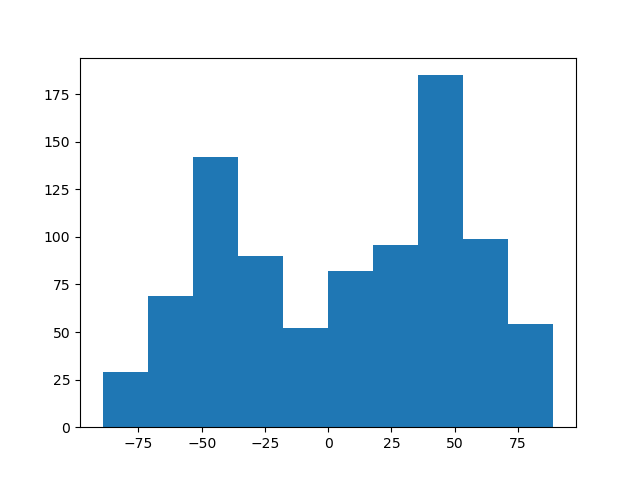

In [35]:
pct = 0
first_last = []
slopes =[]
for i in range(len(good_speed_chains)):
    ras = radecs[0, good_speed_chains[i]]
    decs = radecs[1, good_speed_chains[i]]

    first_last.append([ [ras[0], decs[0]], [ras[-1], decs[-1]] ])
    
    delta_x = ras[-1] - ras[0]
    delta_y = decs[-1] - decs[0]
    
    theta_radians = math.atan2(delta_y, delta_x)
    theta_degrees = math.degrees(theta_radians)
    slopes.append(theta_degrees)

plt.figure()
plt.hist(slopes)

np.save("pt4_S1_898_4_5_chains_SLOPES", slopes)
np.save("pt4_S1_898_4_5_chains_FIRST_LASTs", first_last)

In [30]:
first_last_coords = []
for i in range

In [ ]:
import math
# grouped_rows[0]
first_last_coords = [[g[0], g[-1]] for g in grouped_rows if len(g) >= 4]
slopes = []
for chain in first_last_coords:
    delta_x = chain[1][2] - chain[0][2]
    delta_y = chain[1][3] - chain[0][3]
    theta_radians = math.atan2(delta_y, delta_x)
    theta_degrees = math.degrees(theta_radians)
    slopes.append(theta_degrees)

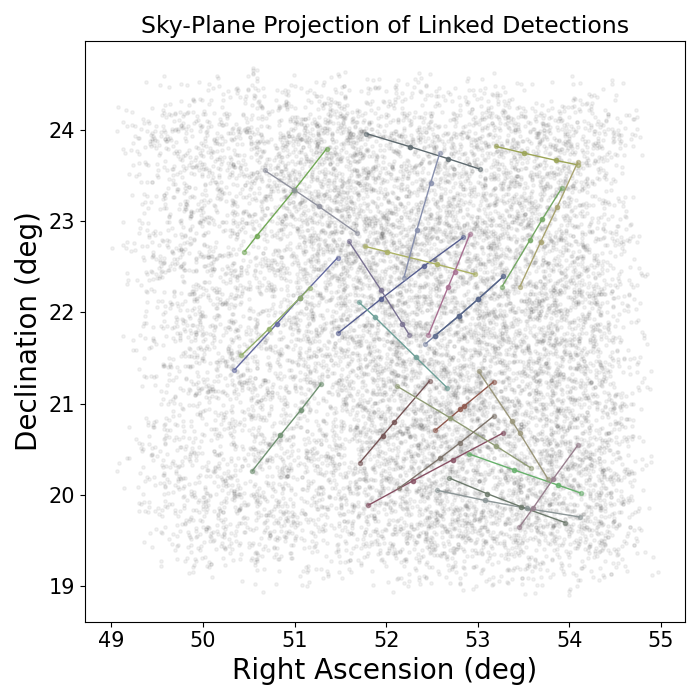

In [34]:
from matplotlib.collections import LineCollection

show_chain_det_ids = True
show_chain_det_ids = False


def generate_random_light_color():
    return np.random.uniform(0.3, 0.7, 3)

fig, ax = plt.subplots(figsize=(7, 7))

# ax.scatter(real_ras, real_decs, marker='s', color='r')
ax.scatter(radecs[0, :], radecs[1, :], color='k', s=6, alpha=0.05)

# For Lines
all_segments = []
colors = []

for i, chain in enumerate(good_speed_chains):
    if len(chain) > 2:
        link_radecs = radecs[:, chain]
        segments = [link_radecs[:, j:j + 2].T for j in range(link_radecs.shape[1] - 1)]
        all_segments.extend(segments)
        
        random_light_color = generate_random_light_color()
        colors.extend([random_light_color] * len(segments))
        
        ra_mean, dec_mean = link_radecs.mean(axis=1)
        # plt.text(ra_mean, dec_mean, s=f'{i}', ha='center', va='bottom', color=random_light_color)
        plt.text(ra_mean, dec_mean, s="", ha='center', va='bottom', color=random_light_color)
        plt.plot()

# Add lines as a LineCollection
lc = LineCollection(all_segments, linewidth=1, colors=colors)
ax.add_collection(lc)

# Add markers
for i, segment in enumerate(all_segments):
    for (ra, dec) in segment:
        ax.plot(ra, dec, marker='o', color=colors[i], linestyle='None', markersize=3, alpha=0.5)

ax.tick_params(axis='both', labelsize=15)
plt.title("Sky-Plane Projection of Linked Detections", fontsize=17)
plt.xlabel("Right Ascension (deg)", fontsize=20)
plt.ylabel("Declination (deg)", fontsize=20)
fig.tight_layout()


In [35]:
plt.close()

# Check speeds

In [87]:
len(good_speed_chains)

87722

In [33]:
good_speed_chains[0:100]

[[3, 2859, 7440],
 [7, 2828, 7355],
 [12, 2889, 7503],
 [13, 2883, 3627],
 [17, 2105, 9190],
 [23, 2883, 7442],
 [24, 2884, 7453, 17427],
 [24, 2885, 7442],
 [27, 2908, 7506],
 [28, 2834, 9103],
 [29, 2834, 7332],
 [30, 2880, 3615],
 [31, 674, 3539],
 [33, 2850, 7366],
 [36, 2911, 9259, 13689],
 [38, 691, 3589],
 [41, 2279, 9325],
 [42, 2236, 9294],
 [46, 2891, 6437],
 [49, 2934, 7528],
 [50, 1341, 3601],
 [53, 2899, 9217],
 [57, 2199, 6446],
 [59, 2893, 7416],
 [60, 2972, 7581],
 [62, 2933, 7500],
 [63, 1337, 2878],
 [64, 2897, 7432],
 [69, 2195, 3621],
 [72, 2974, 5933],
 [76, 2955, 7551],
 [76, 2968, 5927],
 [79, 2220, 3644],
 [81, 2297, 9294],
 [81, 2298, 9295],
 [86, 2221, 6453],
 [86, 2237, 3642],
 [86, 2242, 6454],
 [89, 2957, 6486],
 [91, 2289, 9274],
 [92, 2243, 9211],
 [95, 2986, 9324],
 [99, 2923, 7441],
 [99, 2965, 5911],
 [100, 2967, 6487],
 [101, 1436, 3828],
 [101, 2937, 7455],
 [103, 789, 3757],
 [105, 2337, 3714],
 [106, 2309, 6479],
 [107, 2338, 9297],
 [108, 2263, 92

In [61]:
import pickle

with open("good_speed_chains_v2Apr5searchMar15_linkSettingA.pkl", "wb") as f:
    pickle.dump(good_speed_chains, f)

[28, 360, 894]
50.39198 19.455736 59805.938
Ras:  [50.234642, 50.39198, 50.49726] 

Decs:  [19.42084, 19.455736, 19.47822] 

Mjds:  [59805.35, 59805.938, 59806.33] 

The speeds are:  [0.27504764714389957, 0.2755990244071646] 

The differences are:  [0.0005513772632650404] 



array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

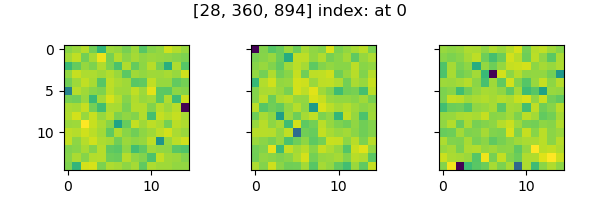

In [36]:
### for x in range(len(good_speed_cleaned_chains)):
x = 0


good_speed_clean_ra = [ras[i] for i in good_speed_chains[x]]
good_speed_clean_dec = [decs[i] for i in good_speed_chains[x]]
good_speed_clean_mjd = [mjds[i] for i in good_speed_chains[x]]

good_clean_speeds = [math.dist([good_speed_clean_ra[i], good_speed_clean_dec[i]], 
                               [good_speed_clean_ra[i+1], good_speed_clean_dec[i+1]]) / 
                                 (good_speed_clean_mjd[i+1] - good_speed_clean_mjd[i]) for i in range(len(good_speed_clean_ra) - 1)]

good_clean_speeds_diffs =  [good_clean_speeds[i+1] - good_clean_speeds[i] for i in range(len(good_clean_speeds)-1)]

print(good_speed_chains[x])

q = 1
print(good_speed_clean_ra[q], good_speed_clean_dec[q], good_speed_clean_mjd[q])

print("Ras: ", good_speed_clean_ra, "\n")
print("Decs: ", good_speed_clean_dec, "\n")
print("Mjds: ", good_speed_clean_mjd, "\n")
print("The speeds are: ", good_clean_speeds, "\n")
print("The differences are: ",good_clean_speeds_diffs ,"\n")

plot_images([ims[i] for i in good_speed_chains[x]], title = str(good_speed_chains[x]) + " index: at %d" % (x), fig_height=2, norm_mode="log")

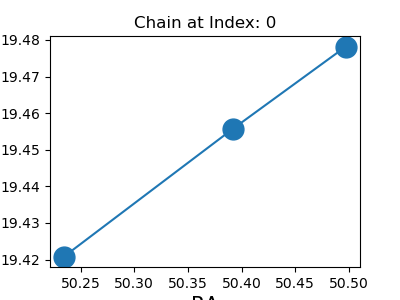

In [37]:
plt.figure(figsize=(4,3))
plt.plot(good_speed_clean_ra, good_speed_clean_dec, "-o",markersize=15)
plt.xlabel("RA", fontsize=15)
plt.ylabel("DEC",fontsize=15)
plt.title("Chain at Index: " + str(x))
plt.show()

# Visualizations

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_asteroid_images_with_coords(ims, pix_coords, start_index=0, n_rows=5):

    n_cols = 10
    n_images = n_rows * n_cols
    end_index = start_index + n_images

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 1.5 * n_rows))
    axes = axes.flatten()

    for i in range(n_images):
        idx = start_index + i
        if idx >= len(ims):
            break

        ax = axes[i]
        im = ims[idx]
        coord = pix_coords[idx]

        ax.imshow(im, cmap='gray', origin='lower')
        circ = patches.Circle((coord[0], coord[1]), radius=2.0, color='red', fill=False, linewidth=1.5)
        ax.add_patch(circ)

        ax.set_xticks([])
        ax.set_yticks([])

    # Turn off remaining axes
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [39]:
ims = np.load("./Searches/v1_images_pt4.npy")
pix_coords = np.load("./Searches/v1_predicted_CoordinatesPixels_pt4.npy")
confidences = np.load("./Searches/v1_confidences_pt4.npy")

# ims = [ims[i] for i in range(len(ims)) if confidences[i] >= 0.8]
# pix_coords = [pix_coords[i] for i in range(len(ims)) if confidences[i] >= 0.8]

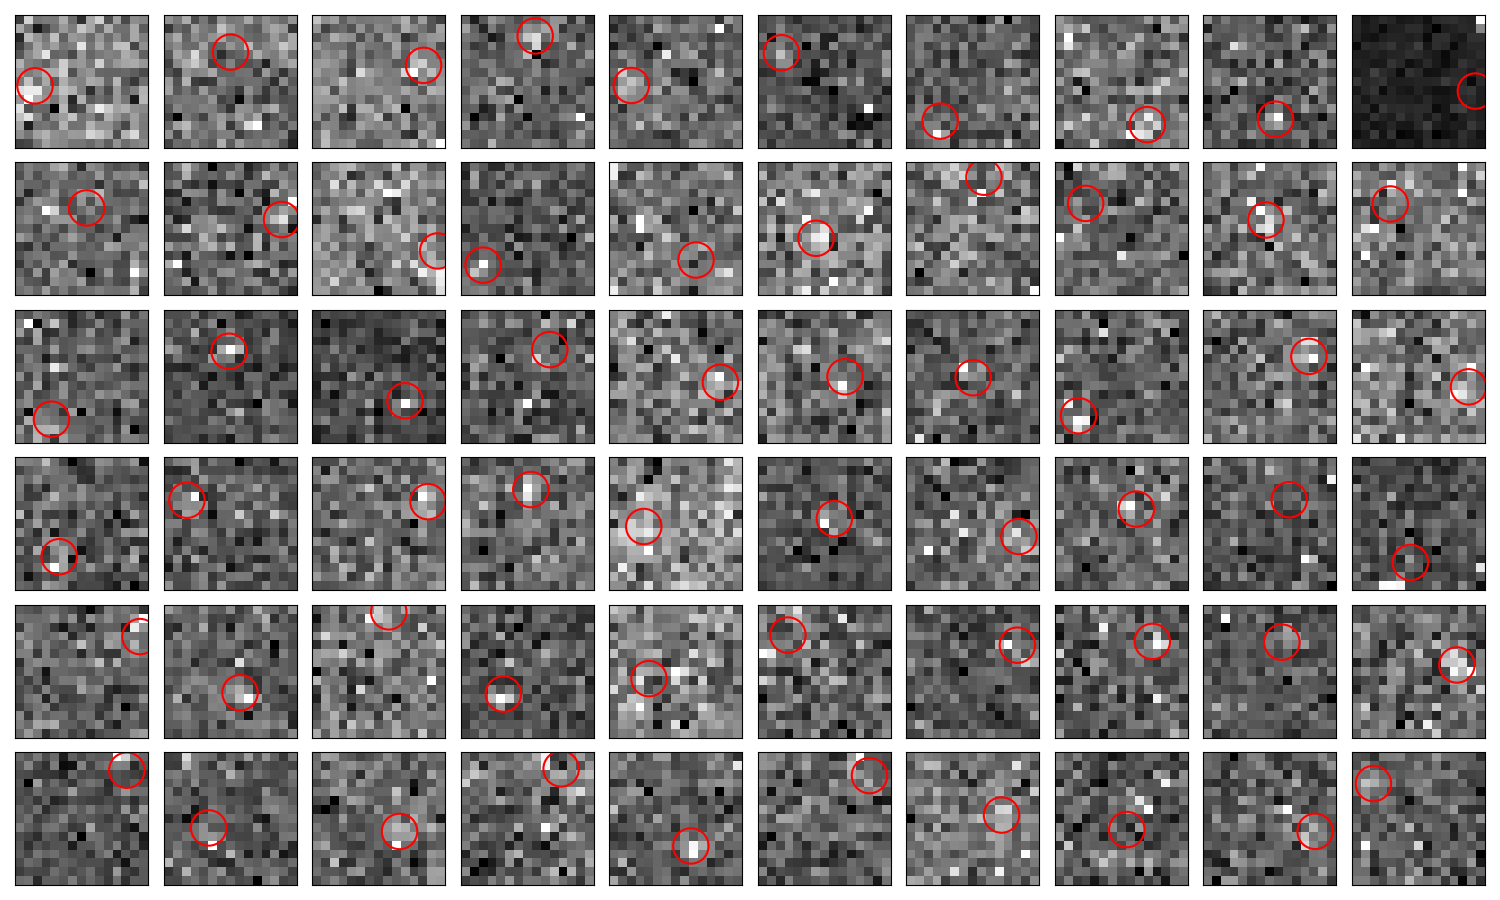

In [38]:
plot_asteroid_images_with_coords(ims, pix_coords, start_index=1200, n_rows=6)

# False alarm probability test

In [82]:
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [105]:
len(all_ims)

687

In [144]:
len(all_confidences)

3389195

In [ ]:

"""
select all 3m searched images
filter out those with conf >= 0.4
- could containing known asteroids
- these are the new image patches

change hist plot integers
change axes labels
"""

In [131]:
all_ims = []
patches = []
patch_size=5
for tracklet in good_speed_angle_chains:
    for idx in tracklet:
        im = ims[idx]
        all_ims.append(im)
        
        
        H, W = (15,15)
        half = patch_size // 2
   
        x, y = int(pix_coords[idx][0]), int(pix_coords[idx][1])

        x_start = np.clip(x - half, 0, W - patch_size)
        y_start = np.clip(y - half, 0, H - patch_size)

        patch = im[y_start:y_start + patch_size, x_start:x_start + patch_size]
        patches.append(patch)


In [132]:
len(patches)

687

In [112]:
len(pix_coords)

143561

In [126]:
plot_images(patches[1])

IndexError: index 1 is out of bounds for axis 0 with size 1

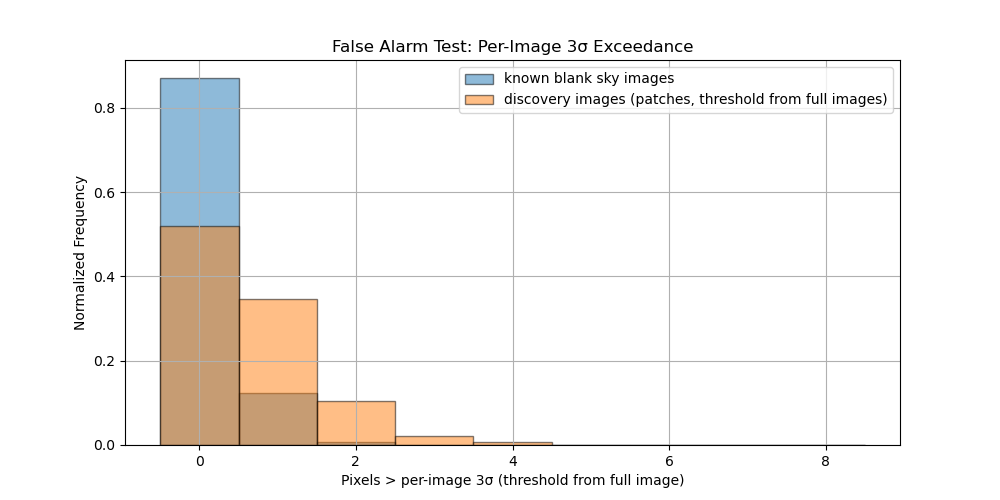

In [137]:
# plt.close()
# A = np.load("./TrainingData/FalseSet/280k_blank_false_images.npy")
# A = A[:, 5:10, 5:10]
# means = A.mean(axis=(1, 2))
# stds = A.std(axis=(1, 2))
# thresholds = means + 3 * stds
# thresholds = thresholds[:, np.newaxis, np.newaxis]
# count_above_3sigma = np.sum(A > thresholds, axis=(1, 2))
# plt.hist(count_above_3sigma, bins=np.arange(0, 10)-0.5, edgecolor='black', label="known blank sky images",density=True)

# all_ims=np.array(all_ims)
# means = all_ims.mean(axis=(1, 2))
# stds = all_ims.std(axis=(1, 2))
# thresholds = means + 3 * stds
# thresholds = thresholds[:, np.newaxis, np.newaxis]
# count_above_3sigma = np.sum(all_ims > thresholds, axis=(1, 2))
# plt.hist(count_above_3sigma, bins=np.arange(0, 10)-0.5, edgecolor='black', label="discoveries images", density=True)

# plt.xlabel('Pixels > per-image 3sigma')
# plt.ylabel('Frequency')
# plt.legend()
# plt.title('False Alarm Test: Per-Image 3sigma Exceedance')
# plt.grid(True)
# plt.show()

import numpy as np
import matplotlib.pyplot as plt

plt.close()
plt.figure(figsize=(10,5))

A_full = np.load("./TrainingData/FalseSet/280k_blank_false_images.npy") 
A_crop = A_full[:, 5:10, 5:10]

means_false = A_full.mean(axis=(1, 2))
stds_false = A_full.std(axis=(1, 2))
thresholds_false = means_false + 3 * stds_false
thresholds_false = thresholds_false[:, np.newaxis, np.newaxis]

count_above_3sigma_false = np.sum(A_crop > thresholds_false, axis=(1, 2))

plt.hist(count_above_3sigma_false, bins=np.arange(0, 10)-0.5, edgecolor='black', alpha=0.5,
         label="known blank sky images", density=True)


# all_ims: full images corresponding to patches
all_ims = np.array(all_ims) 
patches = np.array(patches) 

means_all = all_ims.mean(axis=(1, 2))
stds_all = all_ims.std(axis=(1, 2))
thresholds_all = means_all + 3 * stds_all
thresholds_all = thresholds_all[:, np.newaxis, np.newaxis]

count_above_3sigma_patches = np.sum(patches > thresholds_all, axis=(1, 2))

plt.hist(count_above_3sigma_patches, bins=np.arange(0, 10)-0.5, edgecolor='black',
         label="discovery images (patches, threshold from full images)", density=True, alpha=0.5)

plt.xlabel('Pixels > per-image 3σ (threshold from full image)')
plt.ylabel('Normalized Frequency')
plt.legend()
plt.title('False Alarm Test: Per-Image 3σ Exceedance')
plt.grid(True)
plt.show()


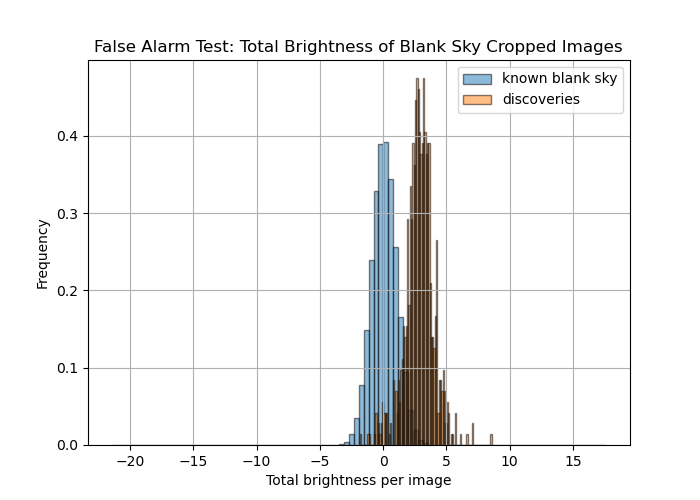

In [143]:
plt.close()
plt.figure(figsize=(7,5))
total_brightness = np.sum(A, axis=(1, 2))
plt.hist(total_brightness[total_brightness <= 20], edgecolor='black', bins=100, label="known blank sky",density=True,alpha=0.5)

total_brightness = np.sum(patches, axis=(1, 2))
plt.hist(total_brightness[total_brightness <= 20], edgecolor='black', bins=100,label="discoveries",density=True,alpha=0.5)


plt.xlabel('Total brightness per image')
plt.ylabel('Count')
plt.title('False Alarm Test: Summed Brightness of Blank Sky Cropped Images')
plt.grid(True)
plt.legend()
plt.show()
